#  定义超参数

In [1]:
#!/usr/bin/env py
import torchvision
from torch.utils.data import DataLoader, random_split
import torch
import syft as sy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import xlwt

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [2]:
class Arguments():
    def __init__(self):
        self.batch_size = 128
        self.epochs = 50
        self.lr = 0.02
        self.num_class = 5
        self.save_name = 'yeo_alexnet_lr0.01_epoch50'
        self.data_train = '/home/raoxy/data/train_yeo'
        self.data_test = '/home/raoxy/data/test_yeo'
        self.flag = True

args = Arguments()
print("现在训练的是：{}".format(args.save_name))
print("使用的训练集：{}".format(args.data_train))
print("使用的测试集：{}".format(args.data_test))

现在训练的是：yeo_alexnet_lr0.01_epoch50
使用的训练集：/home/raoxy/data/train_yeo
使用的测试集：/home/raoxy/data/test_yeo


#  定义参与者

In [3]:
hook = sy.TorchHook(torch)
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")

In [4]:
federated_train_loader = sy.FederatedDataLoader(
    torchvision.datasets.ImageFolder(root=args.data_train,
                                     transform=torchvision.transforms.ToTensor()).federate((bob, alice)),
    batch_size=args.batch_size,
    shuffle=True)

# federated_train_loader = sy.FederatedDataLoader(
# torchvision.datasets.ImageFolder(root=args.data_train,
# transform=torchvision.transforms.Compose([
#                 torchvision.transforms.Resize((224, 224)),
#                 torchvision.transforms.ToTensor(),
#                 torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
#             ]).federate((bob, alice)),
# batch_size=args.batch_size,
# shuffle=True))

In [5]:
federated_test_loader = DataLoader(
    torchvision.datasets.ImageFolder(root=args.data_test,
                                     transform=torchvision.transforms.ToTensor()),
    batch_size=args.batch_size,
    num_workers=0,
    shuffle=False)

# 定义训练函数和测试函数

In [6]:
def train(model, device, federated_train_loader, optimizer):
    model.train()
    correct = 0
    sample_num = 0
    total_loss = 0
    train_batch_num = len(federated_train_loader)

    for idx, (data, target) in enumerate(federated_train_loader):
        model.send(data.location)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.get().data
        pred = output.argmax(1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().get()
        sample_num += len(pred)
        model.get()
    return total_loss / train_batch_num, correct.cpu().item() / sample_num

In [7]:
def test(model, device, federated_test_loader):
    model.eval()
    correct = 0
    total_loss = 0
    sample_num = 0
    test_batch_num = len(federated_test_loader)

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(federated_test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = F.cross_entropy(output, target.long())
            total_loss += loss.data

            pred = output.argmax(1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum()
            sample_num += len(pred)

    return total_loss.cpu() / test_batch_num, correct.cpu().item() / sample_num

 # 定义训练模型
 
 ```
 wget https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
 ```

In [8]:
model_name = '/home/raoxy/model/alexnet-owt-4df8aa71.pth'

# model_name = '/home/raoxy/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth'

def Alexnet(model_name):
    from torchvision.models import alexnet  # 最简单的模型
    from collections import OrderedDict
    pretrain_model = alexnet(pretrained=False)  # 导入了模型的框架
    pretrain_model.classifier[6] = nn.Linear(pretrain_model.classifier[6].in_features, 5)  # 将全连接层改为自己想要的分类输出
    model_dict = pretrain_model.state_dict()
    pretrained_dict = torch.load(model_name)
    pretrained_dict.pop('classifier.6.bias')
    pretrained_dict.pop('classifier.6.weight')
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)  # 模型参数列表进行参数更新，加载参数
    pretrain_model.load_state_dict(model_dict)
    for name, value in pretrain_model.named_parameters():
        if (name != 'classifier.6.weight') and (name != 'classifier.6.bias'):
            value.requires_grad = False
            
    upsample = nn.Upsample(size=[224,224], mode='bilinear', align_corners=True)
    new_model = nn.Sequential(OrderedDict([
                      ('laolao', upsample),
                      ('features', pretrain_model.features),
                      ('avgpool',pretrain_model.avgpool),
                      ('classifier', nn.Sequential(
                                                nn.Flatten(start_dim=1, end_dim=3),
                                                pretrain_model.classifier[0],
                                                pretrain_model.classifier[1],
                                                pretrain_model.classifier[2],
                                                pretrain_model.classifier[3],
                                                pretrain_model.classifier[4],
                                                pretrain_model.classifier[5],
                                                pretrain_model.classifier[6]
                                                 ))
    ])) # 创建一个新的模型
    params_conv = filter(lambda p: p.requires_grad, new_model.parameters())
    return new_model, params_conv

model, params_conv = Alexnet(model_name)
print('现在是在：',device)
optims = optim.SGD(params_conv, lr=args.lr)

现在是在： cpu


# 模型训练

In [10]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
time_list = []
timestart = time.perf_counter()
for epoch in range(1, args.epochs + 1):
    epochstart = time.perf_counter()  # 每一个epoch的开始时间
    train_loss, train_acc = train(model, device, federated_train_loader, optims)
    elapsed = (time.perf_counter() - epochstart)  # 每一个epoch的结束时间 记录训练的耗时
    test_loss, test_acc = test(model, device, federated_test_loader)
    # 保存各个指际
    train_loss_list.append(train_loss.cpu())
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss.cpu())
    test_acc_list.append(test_acc)
    time_list.append(elapsed)
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,time cost %.6f' % (
        epoch, train_loss, test_loss,
        train_acc, test_acc, elapsed))

epoch 1, train_loss 0.041921,test_loss 0.857311,train_acc 0.991346,test_acc 0.798918,time cost 2419.241053
epoch 2, train_loss 0.009681,test_loss 0.035821,train_acc 0.997666,test_acc 0.989240,time cost 2382.191486
epoch 3, train_loss 0.002821,test_loss 0.008623,train_acc 0.999488,test_acc 0.996983,time cost 2401.476786
epoch 4, train_loss 0.001953,test_loss 0.005789,train_acc 0.999658,test_acc 0.997837,time cost 2417.669851
epoch 5, train_loss 0.001731,test_loss 0.003650,train_acc 0.999620,test_acc 0.998634,time cost 2411.240329
epoch 6, train_loss 0.001657,test_loss 0.002723,train_acc 0.999677,test_acc 0.998975,time cost 2364.463459
epoch 7, train_loss 0.001467,test_loss 0.002203,train_acc 0.999677,test_acc 0.999146,time cost 2360.375963
epoch 8, train_loss 0.001545,test_loss 0.001661,train_acc 0.999639,test_acc 0.999317,time cost 2364.095280
epoch 9, train_loss 0.001300,test_loss 0.001428,train_acc 0.999696,test_acc 0.999601,time cost 2364.576560
epoch 10, train_loss 0.001224,test_lo

In [11]:
# 训练数据保存
torch.save(model.state_dict(), "/home/raoxy/model/{}.pt".format(args.save_name))

# 训练数据保存

In [15]:
def _change(a):
    b = []
    for i in a:
        b.append(float(i))
    return b

from datetime import datetime
file_name = '/home/raoxy/file/{}_{}.xlsx'.format(args.save_name,datetime.now())

## 创建workbook和sheet对象

In [17]:
# 创建workbook和sheet对象
workboot = xlwt.Workbook(encoding='utf-8')
worksheet = workboot.add_sheet('results')  # 设置工作表的名字
# 写入Excel标题
row0 = ["Train loss", "Train acc", "Test loss", 'Test acc', 'Time']
for i in range(len(row0)):
    worksheet.write(0, i, row0[i])

In [18]:
test_loss_list = _change(test_loss_list)
train_loss_list = _change(train_loss_list)
train_acc_list = _change(train_acc_list)
test_acc_list = _change(test_acc_list)
time_list = _change(time_list)

length = len(test_loss_list)

for i in range(1, length + 1):
    worksheet.write(i, 0, train_loss_list[i - 1])
    worksheet.write(i, 1, train_acc_list[i - 1])
    worksheet.write(i, 2, test_loss_list[i - 1])
    worksheet.write(i, 3, test_acc_list[i - 1])
    worksheet.write(i, 4, time_list[i - 1])
workboot.save(file_name)
print("保存文件：",file_name)

保存文件： /home/raoxy/file/yeo_alexnet_lr0.01_epoch50_2023-12-04 21:08:01.250525.xlsx


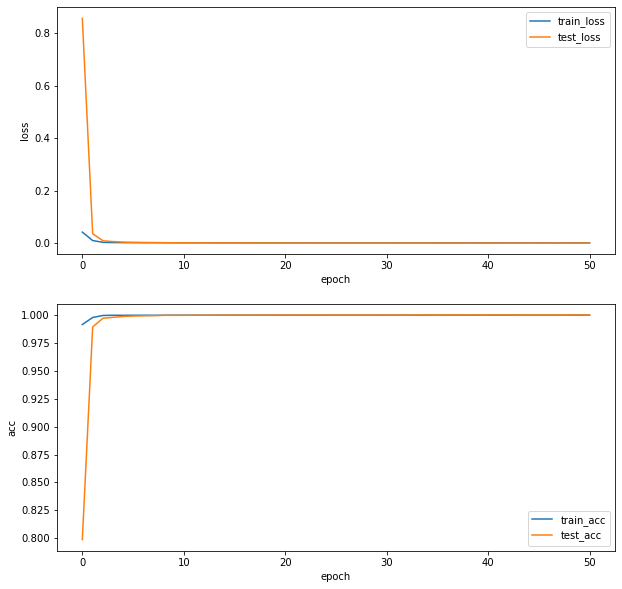

In [19]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np


def plotP(test_loss, train_loss, train_acc_list, test_acc_list):
    plt.figure(figsize=(10, 10))
    x = np.linspace(0, len(train_loss), len(train_loss))
    y = np.linspace(0, len(train_acc_list), len(train_acc_list))
    plt.subplot(2, 1, 1)
    plt.plot(x, train_loss, label="train_loss")
    plt.plot(x, test_loss, label="test_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(y, train_acc_list, label="train_acc")
    plt.plot(y, test_acc_list, label="test_acc")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
#     plt.savefig('../img/{}.png'.format(args.save_name))
    plt.show()

plotP(test_loss_list, train_loss_list, train_acc_list, test_acc_list)

# 结果分析

## 模型预测

### 生成预测的配置文件

In [21]:
import os

verify_root='/home/raoxy/data/verify_yeo/'
true_label_txt='/home/raoxy/file/true_label_alexnet_yeo.txt'

def Create_data_dir_with_true_label(_root, save_name):
    ''':cvar保存每一张图片的地址+对应的正确的标签'''
    _list = []
    for a, b, c in os.walk(_root):
        for i in range(len(c)):
            _list.append(os.path.join(a, c[i]))
    with open(save_name, 'w', encoding='UTF-8') as f:
        for _img in _list:
            f.write(_img + '\t' + str(_img.split('/')[-2]) + '\n')
    print("生成文件成功：",save_name)

Create_data_dir_with_true_label(verify_root, true_label_txt)

生成文件成功： /home/raoxy/file/true_label_alexnet_yeo.txt


In [22]:
verify_root='/home/raoxy/data/verify_yeo/'
predicted_label_txt='/home/raoxy/file/predicted_label_alexnet_yeo.txt'

def Create_data_dir_with_no_label(_root, save_name):
    _list = []
    for a, b, c in os.walk(_root):
        for i in range(len(c)):
            _list.append(os.path.join(a, c[i]))
    # print(_list)
    with open(save_name, 'w', encoding='UTF-8') as f:
        for _img in _list:
            f.write(_img + '\t' + "0" + '\n')
    print("生成文件成功：",save_name)

Create_data_dir_with_no_label(verify_root, predicted_label_txt)

生成文件成功： /home/raoxy/file/predicted_label_alexnet_yeo.txt


### 加载模型

In [33]:
from torchvision.models import alexnet  

def Alexnet(model_name):
    from torchvision.models import alexnet  # 最简单的模型
    from collections import OrderedDict
    pretrain_model = alexnet(pretrained=False)  # 导入了模型的框架
    pretrain_model.classifier[6] = nn.Linear(pretrain_model.classifier[6].in_features, 5)  # 将全连接层改为自己想要的分类输出
#     model_dict = pretrain_model.state_dict()
#     pretrained_dict = torch.load(model_name)
#     pretrained_dict.pop('classifier.6.bias')
#     pretrained_dict.pop('classifier.6.weight')
#     pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
#     model_dict.update(pretrained_dict)  # 模型参数列表进行参数更新，加载参数
#     pretrain_model.load_state_dict(model_dict)
#     for name, value in pretrain_model.named_parameters():
#         if (name != 'classifier.6.weight') and (name != 'classifier.6.bias'):
#             value.requires_grad = False
            
    upsample = nn.Upsample(size=[224,224], mode='bilinear', align_corners=True)
    new_model = nn.Sequential(OrderedDict([
                      ('laolao', upsample),
                      ('features', pretrain_model.features),
                      ('avgpool',pretrain_model.avgpool),
                      ('classifier', nn.Sequential(
                                                nn.Flatten(start_dim=1, end_dim=3),
                                                pretrain_model.classifier[0],
                                                pretrain_model.classifier[1],
                                                pretrain_model.classifier[2],
                                                pretrain_model.classifier[3],
                                                pretrain_model.classifier[4],
                                                pretrain_model.classifier[5],
                                                pretrain_model.classifier[6]
                                                 ))
    ])) # 创建一个新的模型
#     params_conv = filter(lambda p: p.requires_grad, new_model.parameters())
    return new_model

model_loc  = '/home/raoxy/model/yeo_alexnet_lr0.01_epoch50.pt'

model = Alexnet(model_name)  # 导入了模型的框架
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [39]:
state_dict = torch.load(model_loc)
model.load_state_dict(state_dict)

# model.load_state_dict(model_loc)

<All keys matched successfully>

### 预测

In [41]:
# true_label_txt='/home/raoxy/file/true_label_cnn_yeo.txt'
from utils import LoadData, write_result
def eval(dataloader, model):
    label_list = []
    likelihood_list = []
    pred_list = []
    model.eval()
    with torch.no_grad():
        # 加载数据加载器，得到里面的X（图片数据）和y(真实标签）
        for idx, (X, y) in enumerate(dataloader):
            # 将图片传入到模型当中就，得到预测的值pred
            pred = model(X)
            pred_softmax = torch.softmax(pred, 1).cpu().numpy()
            # 获取可能性最大的标签
            label = torch.softmax(pred, 1).cpu().numpy().argmax()
            label_list.append(label)
            # 获取可能性最大的值（即概率）
            likelihood = torch.softmax(pred, 1).cpu().numpy().max()
            likelihood_list.append(likelihood)
            pred_list.append(pred_softmax.tolist()[0])

        return label_list, likelihood_list, pred_list

valid_data = LoadData(true_label_txt  , train_flag=False)
_dataloader = DataLoader(dataset=valid_data, num_workers=4, pin_memory=True, batch_size=1)

label_list, likelihood_list, pred = eval(_dataloader, model)
# print(label_list)
# print(likelihood_list)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

### 将输出保存到exel中，方便后续分析

In [43]:
import pandas as pd

In [44]:
save_name = 'yeo_alexnet_lr0.01_epoch50'

label_names = ['R', 'RPM', 'gear', 'DoS', 'Fuzzy']
df = pd.DataFrame(data=pred, columns=label_names)
df.to_csv('/home/raoxy/file/{}.csv'.format(save_name), encoding='utf-8', index=False)
print('执行完毕，生成文件：/home/raoxy/file/{}.csv'.format(save_name))

执行完毕，生成文件：/home/raoxy/file/yeo_alexnet_lr0.01_epoch50.csv


##  绘图

In [45]:
target_data = pd.read_csv(true_label_txt, sep="\t", names=["loc", "type"])
true_label = [i for i in target_data["type"]]

In [46]:
save_name = 'yeo_alexnet_lr0.01_epoch50'

predict_loc ='/home/raoxy/file/{}.csv'.format(save_name)    # 3.ModelEvaluate.py生成的文件
predict_data = pd.read_csv(predict_loc)#,index_col=0)
predict_label = predict_data.to_numpy().argmax(axis=1)
predict_score = predict_data.to_numpy().max(axis=1)
# predict_score = predict_data.to_numpy().max(axis=1)
# # 精度，准确率， 预测正确的占所有样本种的比例
print(len(predict_label))

17565


In [47]:
from sklearn.metrics import accuracy_score  # pip install scikit-learn
accuracy = accuracy_score(true_label, predict_label)
print("精度: ",accuracy)

精度:  0.7372615997722745


## 查准率P（准确率），precision(查准率)=TP/(TP+FP)

In [48]:
from sklearn.metrics import precision_score
precision = precision_score(true_label, predict_label, labels=None, pos_label=1, average='macro') # 'micro', 'macro', 'weighted'
print("查准率P: ",precision)

查准率P:  0.6812996926560793


/home/raoxy/anaconda3/envs/pysyft/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 查全率R（召回率），原本为对的，预测正确的比例；recall(查全率)=TP/(TP+FN)

In [49]:
from sklearn.metrics import recall_score
recall = recall_score(true_label, predict_label, average='macro') # 'micro', 'macro', 'weighted'
print("召回率: ",recall)

召回率:  0.7393239436619718


## F1-Score

In [50]:
from sklearn.metrics import f1_score

f1 = f1_score(true_label, predict_label, average='macro')     # 'micro', 'macro', 'weighted'
print("F1 Score: ",f1)

F1 Score:  0.6828857157447412


## 混淆矩阵

<Figure size 1080x1080 with 0 Axes>

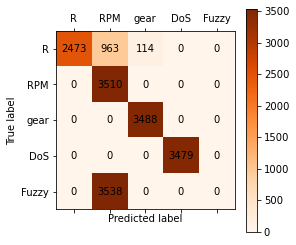

执行完毕，生成文件：/home/raoxy/img/alexnet_yeo_Confusion_Matrix.png


<Figure size 432x288 with 0 Axes>

In [51]:
_fig_title='alexnet_yeo'

from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15, 15))
label_names = ['R', 'RPM',  'gear', 'DoS', 'Fuzzy']
confusion = confusion_matrix(true_label, predict_label, labels=[i for i in range(len(label_names))])
plt.matshow(confusion, cmap=plt.cm.Oranges)   # Greens, Blues, Oranges, Reds
plt.colorbar()
for i in range(len(confusion)):
    for j in range(len(confusion)):
        plt.annotate(confusion[j,i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(range(len(label_names)), label_names)
plt.yticks(range(len(label_names)), label_names)
# plt.title("{} Confusion Matrix".format(_fig_title))
plt.show()
plt.savefig('/home/raoxy/img/{}_Confusion_Matrix.png'.format(_fig_title),bbox_inches="tight")
print('执行完毕，生成文件：/home/raoxy/img/{}_Confusion_Matrix.png'.format(_fig_title))

## ROC曲线

In [54]:
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import label_binarize
n_classes = len(label_names)
# binarize_predict = label_binarize(predict_label, classes=[i for i in range(n_classes)])
binarize_predict = label_binarize(true_label, classes=[i for i in range(n_classes)])
# 读取预测结果
predict_score = predict_data.to_numpy()
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarize_predict[:,i], [socre_i[i] for socre_i in predict_score])
    roc_auc[i] = auc(fpr[i], tpr[i])
print("roc_auc = ",roc_auc)

roc_auc =  {0: 0.9997003411837418, 1: 0.7457132692991819, 2: 0.9999289621368189, 3: 1.0, 4: 0.7502207142060637}


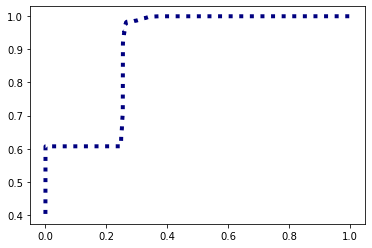

In [56]:
from numpy import interp

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

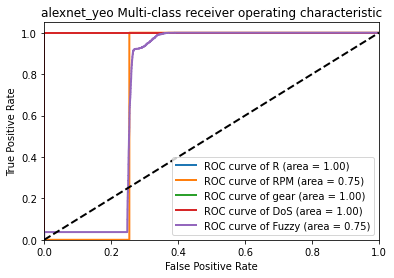

In [57]:
_fig_title='alexnet_yeo'

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(label_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('{} Multi-class receiver operating characteristic'.format(_fig_title))
plt.legend(loc="lower right")
plt.show()
# plt.savefig('../img/{}_roc_fig.png'.format(args._fig_title),bbox_inches="tight")
# print('执行完毕生成文件：../img/{}_roc_fig.png'.format(_fig_title))